In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from nbhelper import *

This notebook presents some exploration and visualisation on two datasets related to visual perception in VR. 

The first one was collected during a pointing in a VR experiment. 12 participants were asked to reach for a target in VR without real feedback. The end position of the reaching motion was recorded. There were 3 conditions: pointing with the left hand, pointing with the right hand, and pointing the right hand onto the left hand. For each condition, 7 targets indicated the locations at which the pointing should have occured.

The second experiment was also a pointing experiment in VR but the visual feedback was manipulated so as to create the illusion of several targets being present in the scene. The positive and negative angles until which the illusion was believable were recorded. These were extracted from a series of trials which sampled the illusion angles. A sigmoid fit was applied to the data and alpha +/- were reported from the sigmoid fit.

The main idea behind these two datasets is to uncover a relationship between the pointing behaviours of participants and their ability to discriminate against optical illusions.

In other words, it is a regression task where we are looking for the relationship:
$$
y = f(x)
$$
where $y$ is the maximum deviation angle for successful optical illusions and $x$ is the user raw pointing performance.

# Read data

In [4]:
df0 = pd.read_csv('./data/Data1stExpe.csv')

In [5]:
df0.columns = ['user', 'condition', 'target', 'trial', 'tx', 'ty', 'px', 'py']

In [6]:
df0.head()

,user,condition,target,trial,tx,ty,px,py
0,1,1,1,1,-0.000048,0.12282,-0.011949,0.13624
1,1,1,1,2,-0.000048,0.12282,-0.016144,0.13269
2,1,1,1,3,-0.000048,0.12282,-0.020195,0.15089
3,1,1,1,4,-0.000033,0.12282,-0.010126,0.12829
4,1,1,1,5,-0.000033,0.12282,-0.016444,0.12576


In [7]:
df1 = pd.read_csv('./data/Data2ndExpe.csv')

In [8]:
df1.columns = ['user', 'target', 'a-', 'a+']

In [9]:
df1.head()

,user,target,a-,a+
0,1,1,-0.079151,0.018782
1,1,2,-0.057142,0.010565
2,1,3,-0.050158,-0.017874
3,1,4,-0.072195,0.026864
4,2,1,-0.124420,-0.038749


# all data from experiment #1

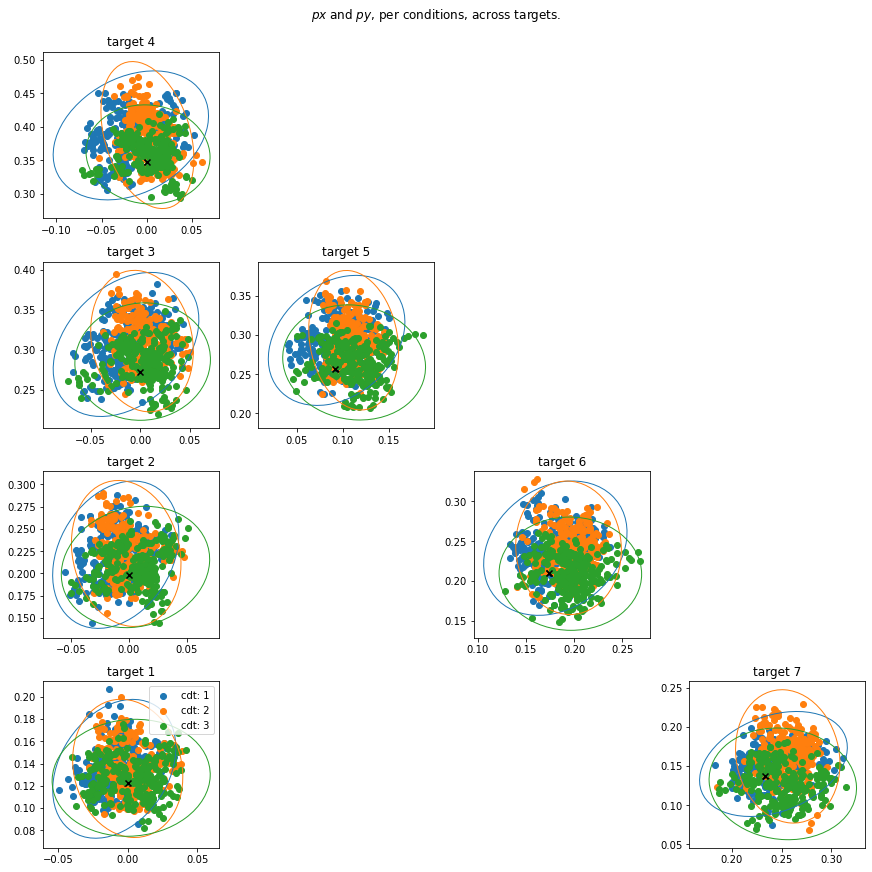

In [11]:
fig2 = plt.figure(constrained_layout=True, figsize=(12,12))
spec2 = gridspec.GridSpec(ncols=4, nrows=4, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[3, 0])
f2_ax2 = fig2.add_subplot(spec2[2, 0])
f2_ax3 = fig2.add_subplot(spec2[1, 0])
f2_ax4 = fig2.add_subplot(spec2[0, 0])
f2_ax5 = fig2.add_subplot(spec2[1, 1])
f2_ax6 = fig2.add_subplot(spec2[2, 2])
f2_ax7 = fig2.add_subplot(spec2[3, 3])
axs = [f2_ax1, f2_ax2, f2_ax3, f2_ax4, f2_ax5, f2_ax6, f2_ax7]

for i, (j, grp) in enumerate(df0.groupby(['target', 'condition'])):
    target = j[0]
    condition = j[1]
    
    scatter = axs[target-1].scatter(grp['px'], grp['py'], label='cdt: '+str(grp['condition'].iloc[0]))
    axs[target-1].scatter(grp['tx'].mean(), grp['ty'].mean(), c='k', marker='x')
    confidence_ellipse(grp['px'], grp['py'], axs[target-1], edgecolor=default_colors[condition-1])
    
    axs[target-1].set_title("target {}".format(target))
    
_=axs[0].legend()
_=fig2.suptitle('$px$ and $py$, per conditions, across targets.')

# Is there a learning effect in the data?

We can wonder whether there is an effect of trial on the pointing behaviour of users, or if we can safely take the mean of end positions.

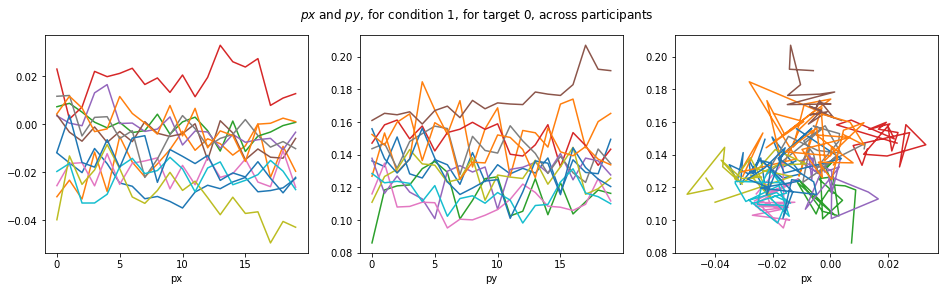

In [15]:
fig, ax = plt.subplots(1,3, figsize=(16,4))

for i, grp in df0.groupby(['target', 'condition', 'user']):
    target = i[0]
    condition = i[1]
    
    if (target == 1) and (condition == 1):
        grp.plot(y='px', use_index=False, ax=ax[0], legend=False)
        ax[0].set_xlabel('px')
        grp.plot(y='py', use_index=False, ax=ax[1], legend=False)
        ax[1].set_xlabel('py')
        grp.plot(x='px', y='py', ax=ax[2], legend=False)
        
_=fig.suptitle('$px$ and $py$, for condition 1, for target 0, across participants')

At first glance, there do not seem to be a learning effect present. I do not have a definitive answer for this question but it might be useful to think about it. 

# user dependent effects in pointing

Here we compute some summary statistics on the user data. Averaging over (user, condition and target), we compute the mean deviation from the target. We also compute the covariance matrix of the user point cloud, with the variance in both dimensions (vx and vy) and the covariance cxy between x and y.

In [19]:
# deviation from target
dx = df0.groupby(['target', 'condition', 'user']).apply(lambda x: x['px'].mean() - x['tx'].mean())
dy = df0.groupby(['target', 'condition', 'user']).apply(lambda x: x['py'].mean() - x['ty'].mean())

# dispersion from target
vx = df0.groupby(['target', 'condition', 'user']).apply(lambda x: np.cov(x[['px', 'py']].T)[0,0])
vy = df0.groupby(['target', 'condition', 'user']).apply(lambda x: np.cov(x[['px', 'py']].T)[1,1])
cxy = df0.groupby(['target', 'condition', 'user']).apply(lambda x: np.cov(x[['px', 'py']].T)[0,1])

In [20]:
data0 = pd.concat([dx, dy, vx, vy, cxy], axis=1)
data0.columns=['dx', 'dy', 'vx', 'vy', 'cxy']
data0 = data0.reset_index()

In [21]:
data0.head()

,target,condition,user,dx,dy,vx,vy,cxy
0,1,1,1,-0.024262,0.009825,0.000043,0.000071,0.000006
1,1,1,2,-0.014780,0.031079,0.000083,0.000294,0.000048
2,1,1,3,-0.000615,-0.006961,0.000027,0.000157,-0.000019
3,1,1,4,0.018119,0.026791,0.000059,0.000080,-0.000004
4,1,1,5,-0.001510,0.004122,0.000048,0.000117,-0.000029


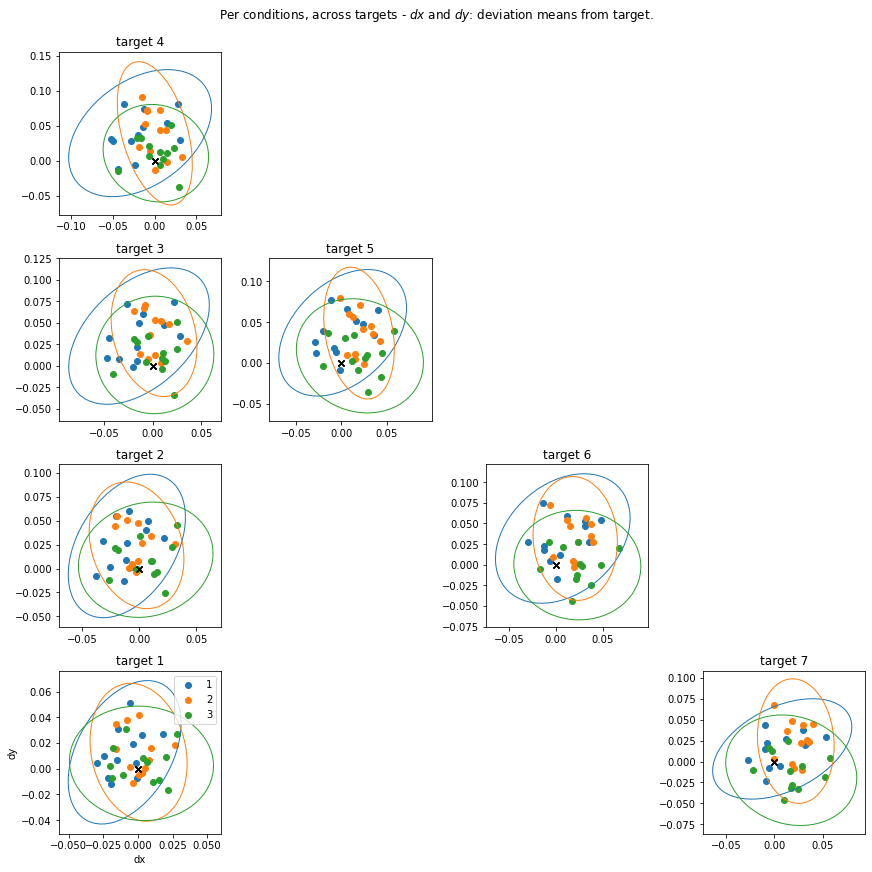

In [26]:
fig2 = plt.figure(constrained_layout=True, figsize=(12,12))
spec2 = gridspec.GridSpec(ncols=4, nrows=4, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[3, 0])
f2_ax2 = fig2.add_subplot(spec2[2, 0])
f2_ax3 = fig2.add_subplot(spec2[1, 0])
f2_ax4 = fig2.add_subplot(spec2[0, 0])
f2_ax5 = fig2.add_subplot(spec2[1, 1])
f2_ax6 = fig2.add_subplot(spec2[2, 2])
f2_ax7 = fig2.add_subplot(spec2[3, 3])
axs = [f2_ax1, f2_ax2, f2_ax3, f2_ax4, f2_ax5, f2_ax6, f2_ax7]

for i, (j, grp) in enumerate(data0.groupby(['target', 'condition'])):
    target = j[0]
    condition = j[1]
    
    scatter = axs[target-1].scatter(grp['dx'], grp['dy'], label=grp['condition'].iloc[0])
    axs[target-1].scatter(0, 0, c='k', marker='x')
    
    color = scatter.to_rgba(0)
    confidence_ellipse(grp['dx'], grp['dy'], axs[target-1], edgecolor=default_colors[condition-1])
    
    axs[target-1].set_title("target {}".format(target))

    
axs[0].legend()
axs[0].set_xlabel('dx')
axs[0].set_ylabel('dy')
_=fig2.suptitle('Per conditions, across targets - $dx$ and $dy$: deviation means from target.')

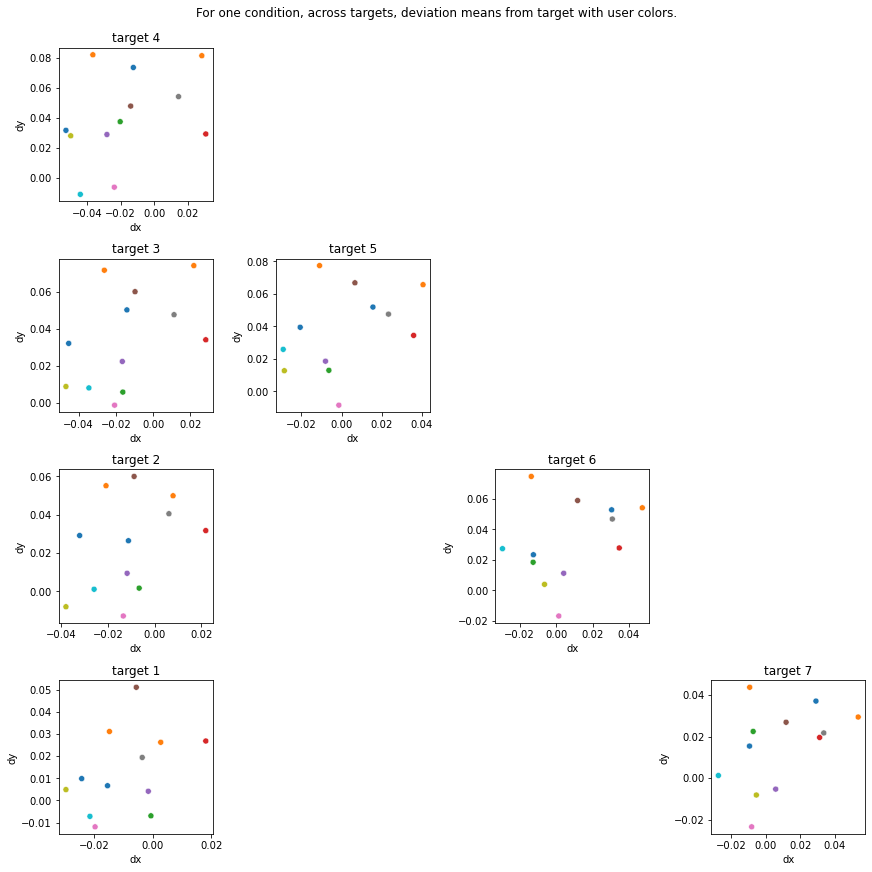

In [16]:
fig2 = plt.figure(constrained_layout=True, figsize=(12,12))
spec2 = gridspec.GridSpec(ncols=4, nrows=4, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[3, 0])
f2_ax2 = fig2.add_subplot(spec2[2, 0])
f2_ax3 = fig2.add_subplot(spec2[1, 0])
f2_ax4 = fig2.add_subplot(spec2[0, 0])
f2_ax5 = fig2.add_subplot(spec2[1, 1])
f2_ax6 = fig2.add_subplot(spec2[2, 2])
f2_ax7 = fig2.add_subplot(spec2[3, 3])
axs = [f2_ax1, f2_ax2, f2_ax3, f2_ax4, f2_ax5, f2_ax6, f2_ax7]

for i, (j, grp) in enumerate(data0.groupby(['target', 'condition'])):
    target = j[0]
    condition = j[1]
    
    if condition == 1:
        sns.scatterplot(data=grp, x='dx', y='dy', hue='user', ax=axs[target-1], legend=False, palette='tab10')
        axs[target-1].set_title("target {}".format(target))

_=fig2.suptitle('For one condition, across targets, deviation means from target with user colors.')

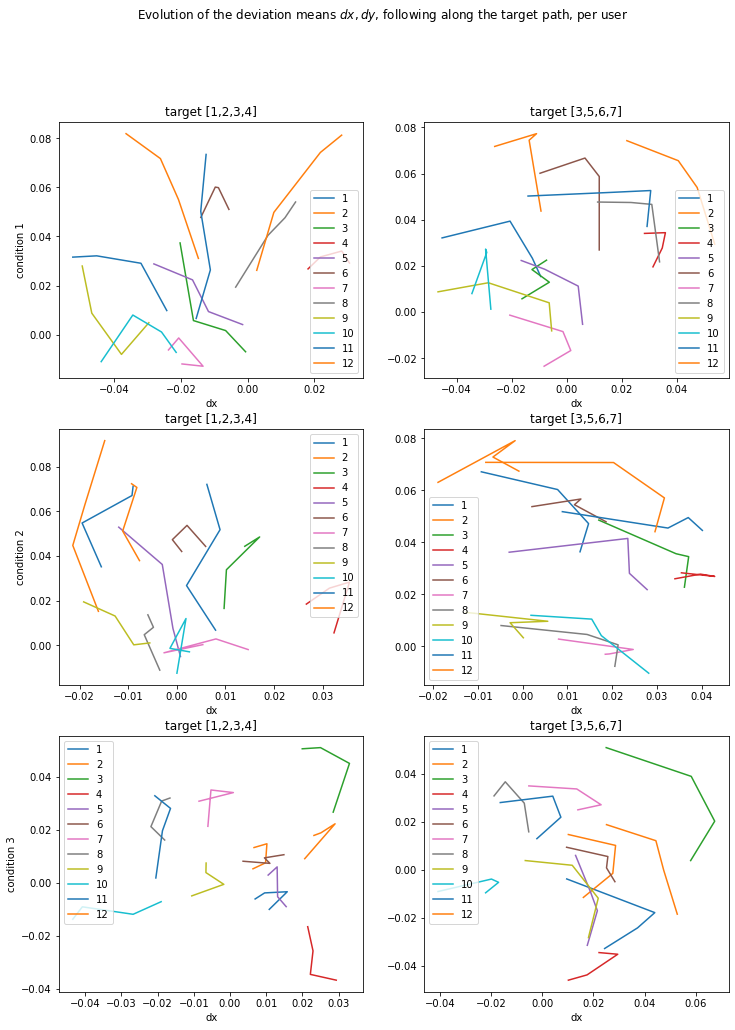

In [29]:
fig, ax = plt.subplots(3, 2, figsize=(12,16))

for i, (j, grp) in enumerate(data0.groupby(['user', 'condition'])):
    user = j[0]
    condition = j[1]
    
    tmp = select(grp, target=[1,2,3,4])
    tmp.plot(x='dx', y='dy', ax=ax[condition-1, 0], label=user)

    tmp = select(grp, target=[3,5,6,7])
    tmp.plot(x='dx', y='dy', ax=ax[condition-1, 1], label=user)

    ax[condition-1, 0].set_title("target [1,2,3,4]")
    ax[condition-1, 1].set_title("target [3,5,6,7]")
    ax[condition-1, 0].set_ylabel("condition {}".format(condition))
    
_=fig.suptitle('Evolution of the deviation means $dx, dy$, following along the target path, per user')

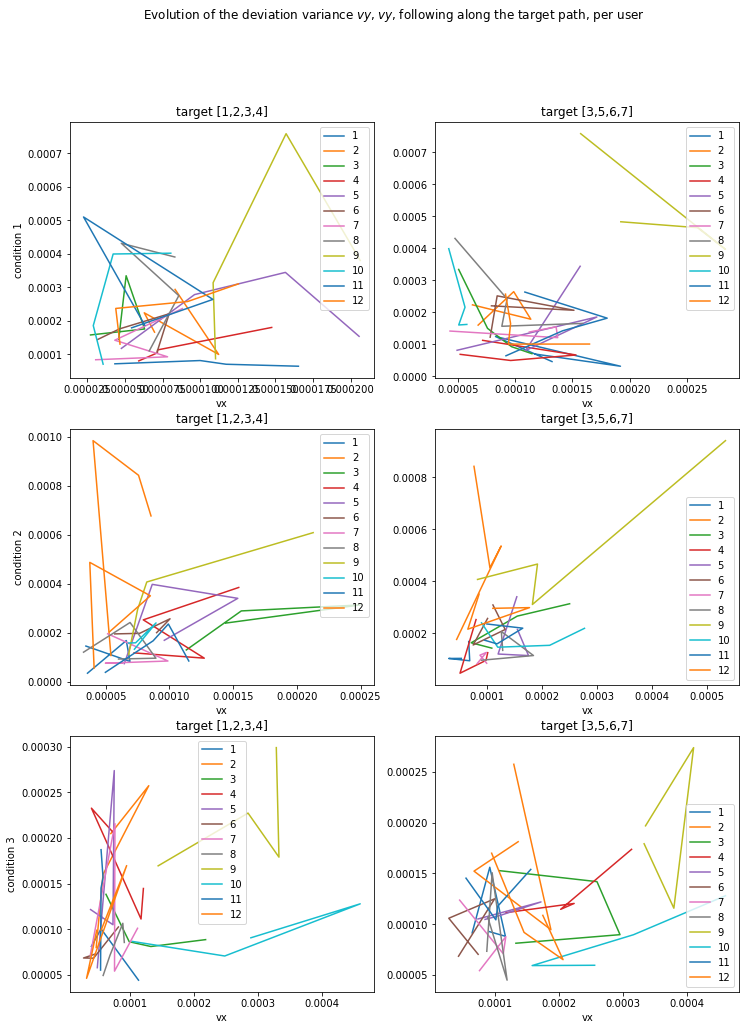

In [30]:
fig, ax = plt.subplots(3, 2, figsize=(12,16))

for i, (j, grp) in enumerate(data0.groupby(['user', 'condition'])):
    user = j[0]
    condition = j[1]
    
    tmp = select(grp, target=[1,2,3,4])
    tmp.plot(x='vx', y='vy', ax=ax[condition-1, 0], label=user)

    tmp = select(grp, target=[3,5,6,7])
    tmp.plot(x='vx', y='vy', ax=ax[condition-1, 1], label=user)

    ax[condition-1, 0].set_title("target [1,2,3,4]")
    ax[condition-1, 1].set_title("target [3,5,6,7]")
    ax[condition-1, 0].set_ylabel("condition {}".format(condition))
    
_=fig.suptitle('Evolution of the deviation variance $vy, vy$, following along the target path, per user')

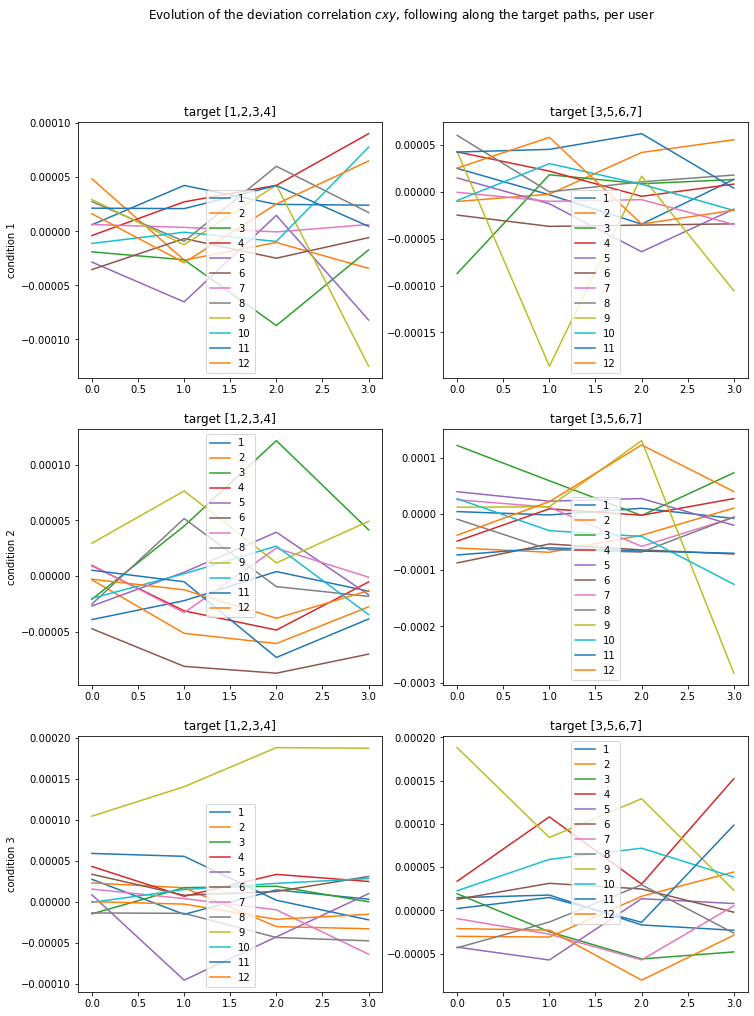

In [32]:
fig, ax = plt.subplots(3, 2, figsize=(12,16))

for i, (j, grp) in enumerate(data0.groupby(['user', 'condition'])):
    user = j[0]
    condition = j[1]
    
    tmp = select(grp, target=[1,2,3,4])
    tmp.plot(y='cxy', ax=ax[condition-1, 0], label=user, use_index=False)

    tmp = select(grp, target=[3,5,6,7])
    tmp.plot(y='cxy', ax=ax[condition-1, 1], label=user, use_index=False)

    ax[condition-1, 0].set_title("target [1,2,3,4]")
    ax[condition-1, 1].set_title("target [3,5,6,7]")
    ax[condition-1, 0].set_ylabel("condition {}".format(condition))
    
_=fig.suptitle('Evolution of the deviation correlation $cxy$, following along the target paths, per user')

In [33]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [34]:
def plot_user_target_distributions(user=i):
    fig2 = plt.figure(constrained_layout=True, figsize=(12,12))
    spec2 = gridspec.GridSpec(ncols=4, nrows=4, figure=fig2)
    f2_ax1 = fig2.add_subplot(spec2[3, 0])
    f2_ax2 = fig2.add_subplot(spec2[2, 0])
    f2_ax3 = fig2.add_subplot(spec2[1, 0])
    f2_ax4 = fig2.add_subplot(spec2[0, 0])
    f2_ax5 = fig2.add_subplot(spec2[1, 1])
    f2_ax6 = fig2.add_subplot(spec2[2, 2])
    f2_ax7 = fig2.add_subplot(spec2[3, 3])
    axs = [f2_ax1, f2_ax2, f2_ax3, f2_ax4, f2_ax5, f2_ax6, f2_ax7]

    for i, (j, grp) in enumerate(df0.groupby(['target', 'condition', 'user'])):
        target = j[0]
        condition = j[1]
        cur_user = j[2]

        if (cur_user == user):        
            scatter = axs[target-1].scatter(grp['px'], grp['py'], label=grp['condition'].iloc[0])
            axs[target-1].scatter(grp['tx'].mean(), grp['ty'].mean(), c='k', marker='x')
            confidence_ellipse(grp['px'], grp['py'], axs[target-1], edgecolor=default_colors[condition-1])

    axs[0].legend()
    fig.suptitle("user {}".format(user))

In [35]:
slider = widgets.IntSlider(min=1, max=12, step=1, value=1)
_=interact(plot_user_target_distributions, user=slider)

interactive(children=(IntSlider(value=1, description='user', max=12, min=1), Output()), _dom_classes=('widget-…

<AxesSubplot:>

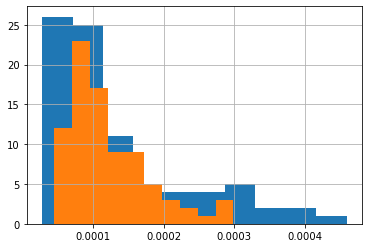

In [36]:
select(data0, condition=3)['vx'].hist()
select(data0, condition=3)['vy'].hist()

# Plot data experiment 2

In [37]:
df1.head()

,user,target,a-,a+
0,1,1,-0.079151,0.018782
1,1,2,-0.057142,0.010565
2,1,3,-0.050158,-0.017874
3,1,4,-0.072195,0.026864
4,2,1,-0.124420,-0.038749


In [38]:
df1['da'] = df1['a+'] - df1['a-']

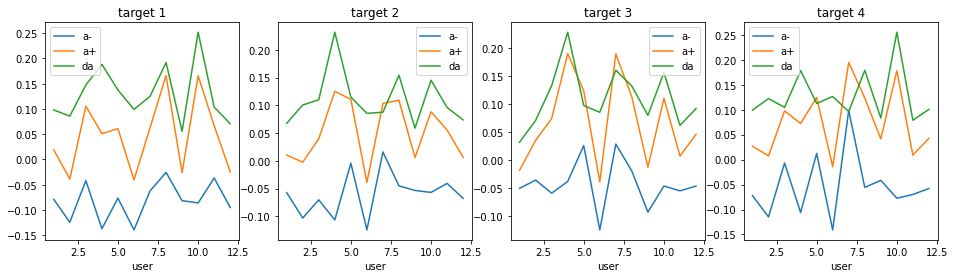

In [39]:
fig, axs = plt.subplots(1,4, figsize=(16,4))
axs = axs.flatten()

# for i, grp in df1.groupby('target'):
#     ax = axs[i-1]
#     grp['-a-'] = -grp['a-']
#     grp.plot(x='user', y='-a-', ax=ax)

for i, grp in df1.groupby('target'):
    ax = axs[i-1]
    grp.plot(x='user', y='a-', ax=ax)
    
for i, grp in df1.groupby('target'):
    ax = axs[i-1]
    grp.plot(x='user', y='a+', ax=ax)
    
for i, grp in df1.groupby('target'):
    ax = axs[i-1]
    grp.plot(x='user', y='da', ax=ax)
    ax.set_title("target {}".format(i))

We find that a+ and a- seem to be correlated across users and targets.

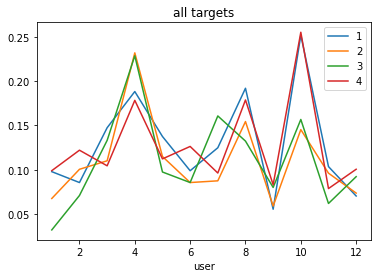

In [40]:
fig, ax = plt.subplots()

for i, grp in df1.groupby('target'):
    grp.plot(x='user', y='da', ax=ax, label=i)
    ax.set_title("all targets")

This picture makes me feel that the value for alpha is independent of the target. In other words, the position at which the illusion occurs does not play a role on its validity - in the conditions of the experiment.

## Distributions of da

It can be interesting to investigate the distribution of da, as this will be the variable we want to predict from the pointing behaviour of users. 

<AxesSubplot:>

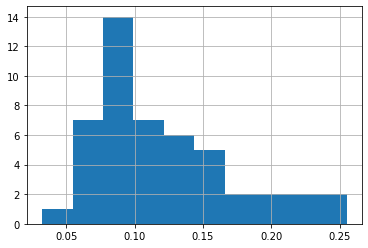

In [41]:
df1['da'].hist()

It seems to be normally distributed in log space.

In [42]:
df1['exp_da'] = np.exp(df1['da'])

<AxesSubplot:>

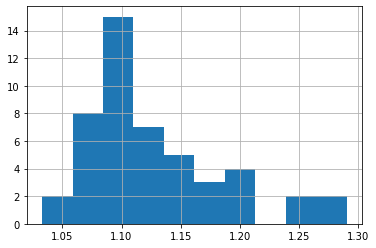

In [43]:
df1['exp_da'].hist()

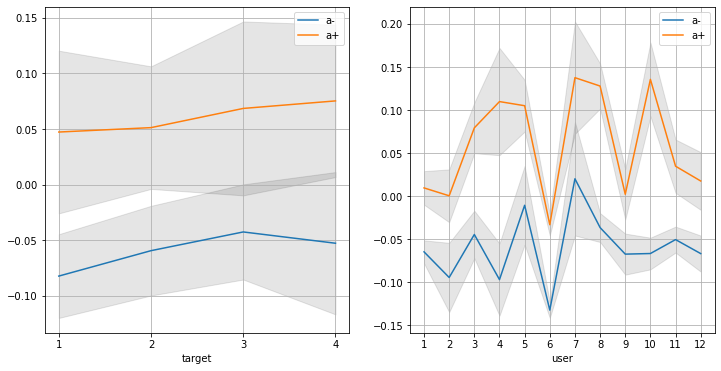

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

# target on alpha
means = df1.groupby('target')[['a-', 'a+']].mean()
stds = df1.groupby('target')[['a-', 'a+']].std()

means.plot(ax=ax[0])
ax[0].fill_between(np.arange(1,5), means['a-']-stds['a-'], means['a-']+stds['a-'], color='k', alpha=0.1)
ax[0].fill_between(np.arange(1,5), means['a+']-stds['a+'], means['a+']+stds['a+'], color='k', alpha=0.1)
ax[0].set_xticks(np.arange(1,5))
ax[0].grid()

# user on alpha
means = df1.groupby('user')[['a-', 'a+']].mean()
stds = df1.groupby('user')[['a-', 'a+']].std()

means.plot(ax=ax[1])
ax[1].fill_between(np.arange(1,13), means['a-']-stds['a-'], means['a-']+stds['a-'], color='k', alpha=0.1)
ax[1].fill_between(np.arange(1,13), means['a+']-stds['a+'], means['a+']+stds['a+'], color='k', alpha=0.1)
ax[1].set_xticks(np.arange(1,13))
ax[1].grid()

There does not seem to be a clear effect of target on alpha, as the mean over user is very noisy. There is however a strong user dependence on the value of alpha.

# relation between pointing performance and alpha?

Given the structure of the data in terms of dependence of alpha against target and user, it seems more interesting to attempt to model the relationship between alpha and users.

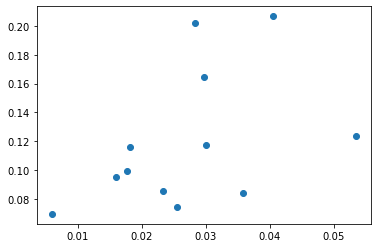

In [45]:
a = df1.groupby('user').mean()['da']
b = select(data0, condition=3).groupby('user').mean()[['dx', 'dy']].apply(np.linalg.norm, axis=1)
plt.scatter(b, a)

This is a naive plot, but it shows a potentially interesting relation: the lower the pointing deviation, the lower is alpha. As the pointing deviation increases, the likelihood of alpha increases too. We also have a bigger spread for alpha, as the pointing deviation increases. It is like a "trumpet".

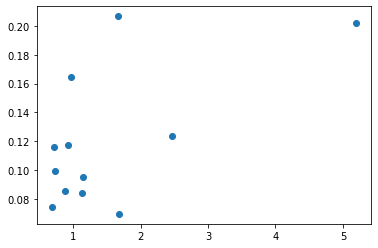

In [46]:
a = df1.groupby('user').mean()['da']
c = select(data0, condition=1).groupby('user').mean()['vx']
d = select(data0, condition=3).groupby('user').mean()['vx']

fig, ax = plt.subplots()
ax.scatter(d/c, a)

If we check the ratio of the variance across x, we find this curve.

In [47]:
c = select(data0, condition=1).groupby('user').mean()[['dx', 'dy']].apply(np.linalg.norm, axis=1)

In [48]:
d = select(data0, condition=2).groupby('user').mean()[['dx', 'dy']].apply(np.linalg.norm, axis=1)

# predict da from (dx, dy, vx, vy, cxy) in conditions 1,2,3

To do so, we will first create our X and y vectors.

In [49]:
data0.head()

,target,condition,user,dx,dy,vx,vy,cxy
0,1,1,1,-0.024262,0.009825,0.000043,0.000071,0.000006
1,1,1,2,-0.014780,0.031079,0.000083,0.000294,0.000048
2,1,1,3,-0.000615,-0.006961,0.000027,0.000157,-0.000019
3,1,1,4,0.018119,0.026791,0.000059,0.000080,-0.000004
4,1,1,5,-0.001510,0.004122,0.000048,0.000117,-0.000029


In [50]:
X = data0.set_index(['target', 'user', 'condition']).unstack()

In [51]:
X = X.reset_index()

In [52]:
# this removes the multiindex from columns, and creates a simpler single index
new_cols = [str(i)+str(j) for (i,j) in pd.Index(X.columns._values, tupleize_cols=False)]

In [53]:
X.columns = new_cols

In [54]:
X.head()

,target,user,dx1,dx2,dx3,dy1,dy2,dy3,vx1,vx2,vx3,vy1,vy2,vy3,cxy1,cxy2,cxy3
0,1,1,-0.024262,-0.015546,0.010835,0.009825,0.035169,-0.009992,0.000043,0.000034,0.000039,0.000071,0.000146,0.000081,0.000006,-0.000039,0.000028
1,1,2,-0.014780,-0.016146,0.006337,0.031079,0.015193,0.005324,0.000083,0.000054,0.000047,0.000294,0.000107,0.000080,0.000048,-0.000003,0.000023
2,1,3,-0.000615,0.009714,0.028480,-0.006961,0.016496,0.026709,0.000027,0.000113,0.000062,0.000157,0.000130,0.000138,-0.000019,-0.000021,-0.000015
3,1,4,0.018119,0.026638,0.021450,0.026791,0.018427,-0.016527,0.000059,0.000072,0.000073,0.000080,0.000118,0.000206,-0.000004,0.000009,0.000043
4,1,5,-0.001510,0.000741,0.015506,0.004122,-0.005080,-0.008956,0.000048,0.000064,0.000049,0.000117,0.000074,0.000058,-0.000029,-0.000027,0.000009


In [55]:
df1.head()

,user,target,a-,a+,da,exp_da
0,1,1,-0.079151,0.018782,0.097933,1.102889
1,1,2,-0.057142,0.010565,0.067707,1.070052
2,1,3,-0.050158,-0.017874,0.032284,1.032811
3,1,4,-0.072195,0.026864,0.099059,1.104131
4,2,1,-0.124420,-0.038749,0.085671,1.089448


In [56]:
y = X[['target', 'user']].copy()
y['da'] = pd.Series()
y = y.set_index(['target', 'user'])

## a. with targets repeated: 7 targets * 12 users

Here, we consider that measurements in experiment 1 and targets [1,2,3,4] are related to the measurement of target 1 in experiment 2, while 5, 6 and 7 are linked to 2, 3 and 4, respectively.

In [57]:
for i, row in X.iterrows():
    user = row['user']
    target = row['target']
    
    target_map = {1:1, 2:1, 3:1, 4:1, 5:2, 6:3, 7:4}
    y.loc[target, user] = df1.set_index(['target', 'user']).loc[target_map[target], user]['da']

In [58]:
y = y.reset_index()

In [59]:
y.head()

,target,user,da
0,1,1,0.097933
1,1,2,0.085671
2,1,3,0.147423
3,1,4,0.188232
4,1,5,0.137563


In [60]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [61]:
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)

In [49]:
inputs = keras.Input(shape=(15,))
x = layers.Dense(15, activation='relu')(inputs)
x = layers.Dense(15, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [50]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense (Dense)                (None, 15)                240       
_________________________________________________________________
dense_1 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 496
Trainable params: 496
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(loss='mse', 
              optimizer=keras.optimizers.SGD())

In [52]:
history = model.fit(X.iloc[:, 2:], y['da'].values, batch_size=16, epochs=200, validation_split=0.2)

Epoch 1/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0196 - val_loss: 0.0145
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0113
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0119 - val_loss: 0.0089
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0071
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0055
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0046
Epoch 7/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0037
Epoch 8/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 9/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 10/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 11/200
5/5 [==========

5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 168/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 169/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 170/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 171/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 172/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 173/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 174/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 175/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 176/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 177/200
5/5 [=====

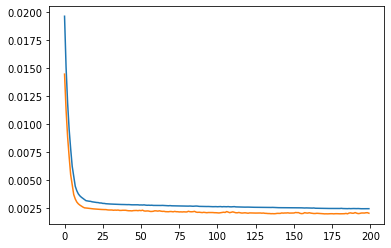

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [54]:
y_pred = model.predict(X.iloc[:, 2:])

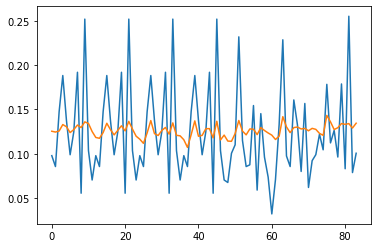

In [55]:
plt.plot(y['da'])
plt.plot(y_pred)

## b. with only 4 targets

In [56]:
X4 = select(X, target=[3,5,6,7]).iloc[:, 2:]

In [57]:
y4 = select(y, target=[3,5,6,7])['da'].values

In [58]:
inputs = keras.Input(shape=(15,))
x = layers.Dense(17, activation='relu')(inputs)
x = layers.Dense(17, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [59]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 17)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 17)                306       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 18        
Total params: 596
Trainable params: 596
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.compile(loss='mse', 
              optimizer=keras.optimizers.SGD())

In [61]:
history = model.fit(X4, y4, batch_size=16, epochs=200, validation_split=0.2)

Epoch 1/200
3/3 [==============================] - 0s 14ms/step - loss: 0.0210 - val_loss: 0.0191
Epoch 2/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0165 - val_loss: 0.0156
Epoch 3/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 4/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 5/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0092 - val_loss: 0.0098
Epoch 6/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0078 - val_loss: 0.0086
Epoch 7/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0074
Epoch 8/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0057 - val_loss: 0.0066
Epoch 9/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 10/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0054
Epoch 11/200
3/3 [==========

3/3 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 168/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 169/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 170/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 171/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 172/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 173/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 174/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 175/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 176/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 177/200
3/3 [=====

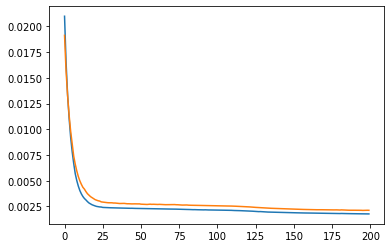

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [63]:
y4_pred = model.predict(X4)

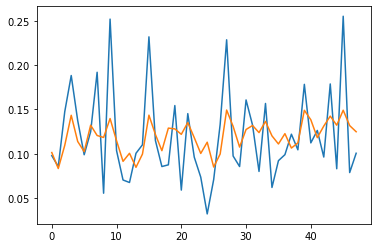

In [64]:
plt.plot(y4)
plt.plot(y4_pred)

As I mentionned, the use of neural networks for this task seems unappropriate: the data to be modelled is scarce and noisy, the distribution to be learned is not gaussian.

# check model generalisation with cross-validation

In [65]:
from sklearn.model_selection import KFold, RepeatedKFold

In [66]:
kf = KFold(n_splits=12)
rkf = RepeatedKFold(n_splits=4, n_repeats=3, random_state=1234)

In [67]:
for train, test in kf.split(np.arange(1,13)):
    print("%s %s" % (train, test))

[ 1  2  3  4  5  6  7  8  9 10 11] [0]
[ 0  2  3  4  5  6  7  8  9 10 11] [1]
[ 0  1  3  4  5  6  7  8  9 10 11] [2]
[ 0  1  2  4  5  6  7  8  9 10 11] [3]
[ 0  1  2  3  5  6  7  8  9 10 11] [4]
[ 0  1  2  3  4  6  7  8  9 10 11] [5]
[ 0  1  2  3  4  5  7  8  9 10 11] [6]
[ 0  1  2  3  4  5  6  8  9 10 11] [7]
[ 0  1  2  3  4  5  6  7  9 10 11] [8]
[ 0  1  2  3  4  5  6  7  8 10 11] [9]
[ 0  1  2  3  4  5  6  7  8  9 11] [10]
[ 0  1  2  3  4  5  6  7  8  9 10] [11]


In [68]:
for train, test in rkf.split(np.arange(1,13)):
    print("%s %s" % (train, test))

[ 0  1  2  3  4  5  6  9 10] [ 7  8 11]
[ 0  1  3  4  5  6  7  8 11] [ 2  9 10]
[ 2  3  5  6  7  8  9 10 11] [0 1 4]
[ 0  1  2  4  7  8  9 10 11] [3 5 6]
[ 0  1  3  4  5  6  8  9 10] [ 2  7 11]
[ 0  2  4  5  6  7  8 10 11] [1 3 9]
[ 1  2  3  6  7  8  9 10 11] [0 4 5]
[ 0  1  2  3  4  5  7  9 11] [ 6  8 10]
[ 0  2  3  5  6  8  9 10 11] [1 4 7]
[ 0  1  2  4  5  6  7  8 11] [ 3  9 10]
[ 0  1  2  3  4  5  7  9 10] [ 6  8 11]
[ 1  3  4  6  7  8  9 10 11] [0 2 5]


In [69]:
def get_model():
    inputs = keras.Input(shape=(15,))
    x = layers.Dense(4, activation='relu')(inputs)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.compile(loss='mse', optimizer=keras.optimizers.SGD())
    return model

In [70]:
res = []

for i, (train, test) in enumerate(rkf.split(np.arange(1,13))):
    print("{}: {} {}".format(i, train, test))

    model = get_model()
    
    grouped = X.groupby('user')
    x_train = pd.concat([grouped.get_group(i+1) for i in train]).iloc[:, 2:]
    x_test = pd.concat([grouped.get_group(i+1) for i in test]).iloc[:, 2:]
    grouped = y.groupby('user')
    y_train = pd.concat([grouped.get_group(i+1) for i in train])['da'].values
    y_test = pd.concat([grouped.get_group(i+1) for i in test])['da'].values
    
    history = model.fit(x_train, y_train, batch_size=2, epochs=25, validation_split=0.2, verbose=0)
    y_pred = model.predict(x_test)
    loss = model.evaluate(x_test, y_test)
    res.append((loss, y_test, y_pred))

0: [ 0  1  2  3  4  5  6  9 10] [ 7  8 11]
1/1 [==============================] - 0s 518us/step - loss: 0.0029
1: [ 0  1  3  4  5  6  7  8 11] [ 2  9 10]
1/1 [==============================] - 0s 710us/step - loss: 0.0052
2: [ 2  3  5  6  7  8  9 10 11] [0 1 4]
1/1 [==============================] - 0s 558us/step - loss: 0.0018
3: [ 0  1  2  4  7  8  9 10 11] [3 5 6]
1/1 [==============================] - 0s 503us/step - loss: 0.0024
4: [ 0  1  3  4  5  6  8  9 10] [ 2  7 11]
1/1 [==============================] - 0s 524us/step - loss: 0.0020
5: [ 0  2  4  5  6  7  8 10 11] [1 3 9]
1/1 [==============================] - 0s 553us/step - loss: 0.0087
6: [ 1  2  3  6  7  8  9 10 11] [0 4 5]
1/1 [==============================] - 0s 511us/step - loss: 0.0018
7: [ 0  1  2  3  4  5  7  9 11] [ 6  8 10]
1/1 [==============================] - 0s 488us/step - loss: 0.0023
8: [ 0  2  3  5  6  8  9 10 11] [1 4 7]
1/1 [==============================] - 0s 504us/step - loss: 0.0018
9: [ 0  1  2  4 

In [71]:
loss = [tmp[0] for tmp in res]
y_test = np.array([tmp[1] for tmp in res])
y_pred = np.array([tmp[2] for tmp in res])

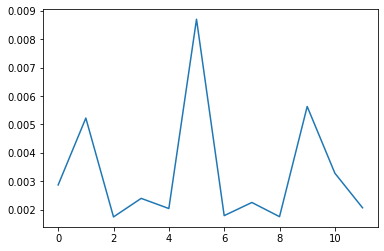

In [72]:
plt.plot(loss)

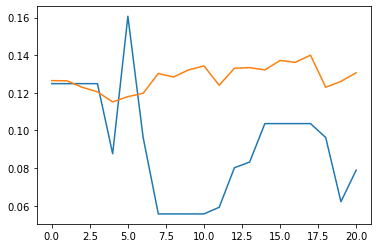

In [73]:
plt.plot(y_test[7])
plt.plot(y_pred[7])

(array([ 3.,  3., 11., 85., 55., 48., 34.,  9.,  2.,  2.]),
 array([0.0853973 , 0.09491315, 0.10442902, 0.11394489, 0.12346075,
        0.1329766 , 0.14249247, 0.15200834, 0.1615242 , 0.17104006,
        0.18055592], dtype=float32),
 <BarContainer object of 10 artists>)

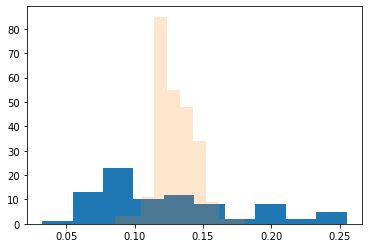

In [74]:
plt.hist(y['da'])
plt.hist(y_pred.reshape(-1), alpha=0.2)

(array([ 3.,  3., 11., 85., 55., 48., 34.,  9.,  2.,  2.]),
 array([0.0853973 , 0.09491315, 0.10442902, 0.11394489, 0.12346075,
        0.1329766 , 0.14249247, 0.15200834, 0.1615242 , 0.17104006,
        0.18055592], dtype=float32),
 <BarContainer object of 10 artists>)

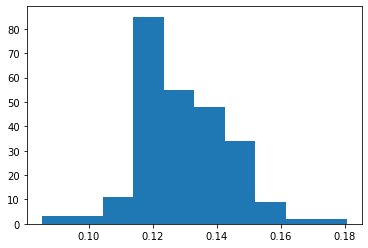

In [75]:
plt.hist(y_pred.reshape(-1))

# using GPs

In [76]:
import GPy

In [77]:
kernel = GPy.kern.RBF(input_dim=15, variance=1., lengthscale=1.)

In [83]:
m = GPy.models.GPRegression(X4,y4.reshape(-1,1),kernel)

In [79]:
display(m)

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [80]:
m.optimize(messages=True)

In [81]:
y_pred, yv_pred = m.predict(X4.values)

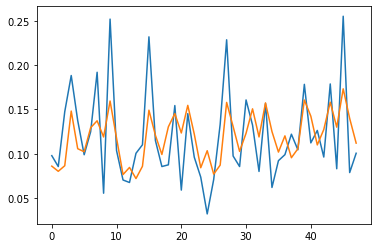

In [82]:
plt.plot(y4)
plt.plot(y_pred)
# plt.fill_between(np.arange(y_pred.shape[0]), (y_pred - 2*yv_pred).reshape(-1), (y_pred + 2*yv_pred).reshape(-1))